# Final Project. Crazy Goodz

<i> Artem Moskalev. Nikita Chizov. Nikita Endaltsev. Vladimir Pimkin.<br>

### Initial variables:

Problem formulation and parameters description:

1. Shop is represented as a graph. Each node can hold a number of products <= integer number c. Graph has a start and an end nodes - s and t (can be also viewed as source and sink from maxflow problem)

_ProbabilityToComeForProduct_ - np.array of size N (number of products), where _ProbabilityToComeForProduct_[i] is a probability of a customer coming with intent to buy product i

_ProbabilityToBuyProductIfPassing_ - np.array of size N, where _ProbabilityToBuyProductIfPassing_[i] is a probability of customer buying product i, conditioned on customer coming close to product i

_PriceOfProduct_ - np.array os size N with prices for each product

_ProductPlacement_ - np.array of shape [N x ShopSize]. ProductPlacement[i, j] = 1 if product i is in the node j

In [2]:
import sys
import numpy as np
import scipy as sp
import scipy.sparse as sps
import pandas as pd
from numpy.random import randint as rint
import matplotlib.pyplot as plt
import networkx as nx

if sys.version_info < (3, 6):
    from random import choice as choices
else:
    from random import choices

%matplotlib inline

In [3]:
class Base(object):
    def __init__(self):
        self.N = 500 # number of products
        self.PriceOfProduct = np.random.rand(self.N)
        self.ProbabilityToComeForProduct = np.abs(np.random.randn(self.N))
        
        self.ProbabilityToComeForProduct = self.ProbabilityToComeForProduct / np.sum(self.ProbabilityToComeForProduct)
        self.ProbabilityToBuyProductIfPassing = np.abs(np.random.randn(self.N))

        # we actually don't need to normalize this probabilities, since they are kind of independent, but for the sake of 
        # being realistic, we will make them rather small
        self.ProbabilityToBuyProductIfPassing = (self.ProbabilityToBuyProductIfPassing / (5.*np.max(self.ProbabilityToBuyProductIfPassing)))
        # also, lets assume that only 20% of the products are appealing enought to be bought on a whim
        self.ProbabilityToBuyProductIfPassing[np.int(0.2 * self.N):] = 0.    
    
    def category_init(self, visualize=True):
        # lets introduce categories. We will add to objective function sum for all shelfs (nodes) of maximum number of 
        # products on that shelf from one category
        Sum = 0
        MinNumberOfCatories = 20 # number of categories is random and lies between this two numbers
        MaxNumberOfCatories = 30

        # size of each category is also random
        CurentCategotySize = np.random.randint(self.N / MaxNumberOfCatories, self.N / MinNumberOfCatories + 1)
        Sum += CurentCategotySize
        self.Categories = np.zeros(self.N)
        self.Categories[:CurentCategotySize] = 1

        while (Sum < self.N):
            CurentCategotySize = np.random.randint(self.N / MaxNumberOfCatories, self.N / MinNumberOfCatories + 1)
            if (Sum + CurentCategotySize > self.N):
                CurentCategotySize = self.N - Sum
            NewCategory = np.zeros(self.N)
            NewCategory[Sum : Sum + CurentCategotySize] = 1
            Sum += CurentCategotySize
            self.Categories = np.vstack((self.Categories, NewCategory))
        
        if visualize:
            # Categories is matrix of shape ([number of categories] x [number of products])
            plt.spy(self.Categories, aspect=self.N / self.Categories.shape[0])
            plt.show()

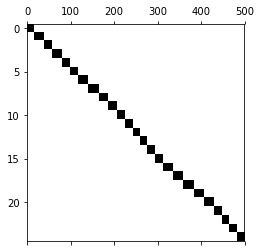

In [4]:
n = Base()
n.category_init()

Making sure probabilities are normalized: 
Sum(ProbabilityToComeForProduct) = 1.0


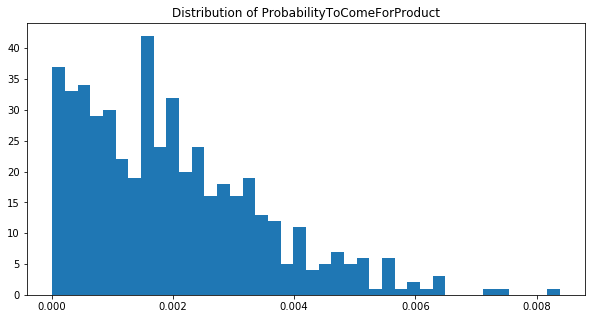

In [5]:
print("Making sure probabilities are normalized: ")
print("Sum(ProbabilityToComeForProduct) = {}".format(np.sum(n.ProbabilityToComeForProduct)))

plt.figure(figsize=(10, 5))
plt.title('Distribution of ProbabilityToComeForProduct')
plt.hist(n.ProbabilityToComeForProduct, bins=40)
plt.show()

### Represent the shop as a graph:

###### function: calculate_distances:  Let's calculate the distances from each node to others and define its predecessors:

We will calculate a matrix of predecessor node, where $PredecessorMatrix[i, j]$ means that if you want to get from node $j$ to node $i$ you should go to node $PredecessorMatrix[i, j]$ and repeat until $PredecessorMatrix[i, j] == i == j$. Same logic with distance matrix (and it's symmetrical).

In [6]:
from scipy.sparse import lil_matrix
from operator import itemgetter as it

class GraphCls(object):
    
    def __init__(self, n):
        self.n = n
        self.ShopSize = 30
        self.c = (self.n.N // self.ShopSize) * 2
        
        self.Shop = self.GetRandomGraph(
            size=self.ShopSize,
            additional_connections_factor=20
        )
        
        self.G = nx.from_scipy_sparse_matrix(self.Shop)
    
    def visualize_shop(self):
        self.pos = nx.spring_layout(self.G, iterations=15000)
        plt.figure(figsize=(12, 12))
        nx.draw_networkx(self.G, pos=self.pos,node_size=350, cmap='seismic', with_labels=False)
        plt.title('Just the map of our shop')
        plt.show()

    def GetRandomGraph(self, size=100, additional_connections_factor=30):
        G = nx.connected_watts_strogatz_graph(size, 3, 0.5, tries=100) #best
        adj=lil_matrix(nx.adjacency_matrix(G))
        for i in range(adj.shape[0]):
            adj[i,i] = 1.
            
        #just making number of additional connections proportional to size of the shop
        for _ in range(self.ShopSize // additional_connections_factor):  
            i = j = 0
            while np.abs(i - j) <= 10:
                i, j = rint(1, self.ShopSize), rint(1, self.ShopSize)
            adj[i, j] = 1
        return adj

    def GetGraphColors(self, SomeProductPlacement):
        cat_color = self.n.Categories @ SomeProductPlacement
        cat_color_map = [np.argmax(row) for row in cat_color]
        for _ in range(self.ShopSize - len(cat_color_map)):
            cat_color_map += [0]
    
        prob_color_map = (self.n.ProbabilityToComeForProduct @ SomeProductPlacement) * 1000
        passing_color_map = (self.n.ProbabilityToBuyProductIfPassing @ SomeProductPlacement) * 1000 
        return cat_color_map, list(prob_color_map), list(passing_color_map)
    
    def calculate_distances(self):
        self.PredecessorMatrix, self.DistanceMatrix = nx.dijkstra_predecessor_and_distance(self.G, 0)
    
        _a = []
        for j, (k, v) in enumerate(self.PredecessorMatrix.items()):
            if j < self.ShopSize > k > 0:
                _a.append(v[0] if v else k)
        self.PredecessorMatrix = _a
        
        self.DistanceMatrix = np.array(
            [self.DistanceMatrix[j] for j in range(self.ShopSize)]
        )

        for i in range(1, self.ShopSize):
            predecessor, distance = nx.dijkstra_predecessor_and_distance(self.G, i)
            
            _aa = []
            for j, (k, v) in enumerate(predecessor.items()):
                if j < self.ShopSize > k > 0:
                    _aa.append(v[0] if v else k)              
            predecessor = _aa
            distance = np.array([distance[j] for j in range(self.ShopSize)])
    
            self.PredecessorMatrix = np.vstack((self.PredecessorMatrix, predecessor))
            self.DistanceMatrix = np.vstack((self.DistanceMatrix, distance))   

In [7]:
gc = GraphCls(n)
gc.calculate_distances()

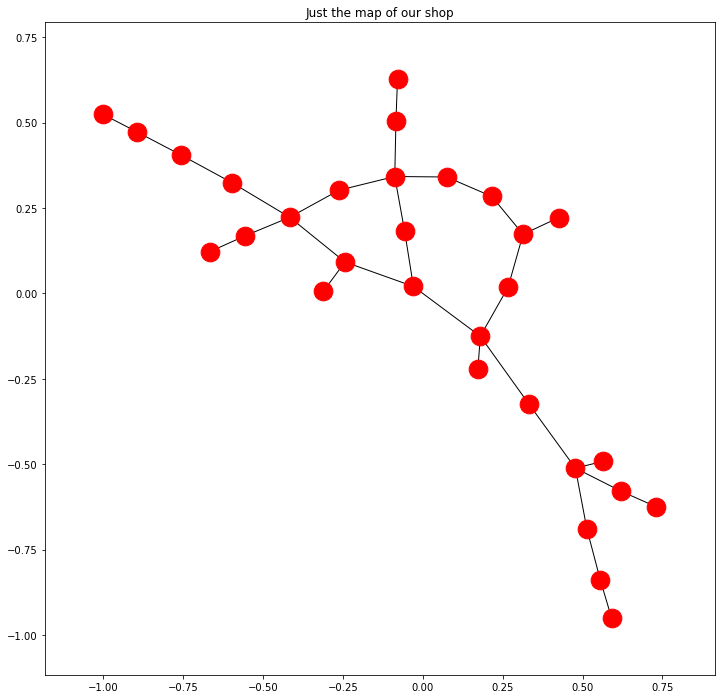

In [8]:
gc.visualize_shop()

We will precompute expectation of the amount of money customer pays if he passes near product (for all products):

In [9]:
ExpectedProfitIfPassingProduct = n.ProbabilityToBuyProductIfPassing * n.PriceOfProduct

###### Objective function:

Objective is composed of three parts:

- The amount of money customers leave on unplanned aquisitions 

- Second part shows how easy it is to find needed product, by encouraging products in the same category to be placed on the same node (shelf)

- Third is a penalty for concentrating too much products in few shelfs (easier to add such a penalty then restrict it by low capacity)



Fisrt part of the objective is calculated as follows:
   
1. we find "importace" of each node (shelf), which have aproximated meaning of how often customers pass by it. 
   For that we consider two parts:<br>

    1.1 How likely is customer to go to each node (it is ProbabilityToComeForProduct @ ProductPlacement)<br>
    1.2 How far other nodes from those to which customers are likely to come. This is actualy a weighted average of rows of DistanceMatrix

In [46]:
def GenerateRandomSolution(Shop):
    """ Function that generates a random solution.
    
    Returns: ProductPlacement - np.array of shape (N, ShopSize)"""
    
    feasible = False
    
    while(not feasible):
        
        ProductShelfs = np.random.randint(0, gc.ShopSize, n.N)
        
        ProductPlacement = np.zeros((n.N, gc.ShopSize))
        
        ProductPlacement[range(n.N), ProductShelfs] = 1
        
        if(np.any(np.sum(ProductPlacement, axis=0) <= gc.c)):
            feasible = True
    
    return ProductPlacement
    
# this is a coeffitient for normalizing the profit part of the objective function. 
# Its calculated as a value of the profit part of the objective for random solution
ProductPlacement = GenerateRandomSolution(gc.Shop)
NormalizationCoeffitient = np.sum(gc.DistanceMatrix * (n.ProbabilityToComeForProduct @ ProductPlacement), axis=0)
NormalizationCoeffitient = np.sum((ProductPlacement @ NormalizationCoeffitient) * ExpectedProfitIfPassingProduct)
    
def DeterministicObjective (ProductPlacement):

    if(np.any(np.sum(ProductPlacement, axis=0) > gc.c)):
        return -np.inf # trying to put to much products in one node, solution not feasible, -inf objective
    
    if(np.any(np.sum(ProductPlacement, axis=1) != 1)):
        return -np.inf # some product is not placed anywhere or at more places then 1, solution not feasible, -inf objective
    
    weights = np.sum(gc.DistanceMatrix * (n.ProbabilityToComeForProduct @ ProductPlacement), axis=0)
    
    Objective = (np.sum((ProductPlacement @ weights) * ExpectedProfitIfPassingProduct)/NormalizationCoeffitient + 
                 np.sum(np.max((n.Categories @ ProductPlacement), axis=0))/n.N -
                 (np.max(np.sum(ProductPlacement, axis=0)) - np.min(np.sum(ProductPlacement, axis=0)))/(n.N/gc.ShopSize))
                              
        
    return Objective


def GetFullPath(NodeList):
    """ We asume that customer travels through the shop in the folowing way:
    1. He goes to the closest shelf, containing any of the products he came for
    2. Then, from there he goes to the second closest, counting from the entrance (and NOT from the previous checkpoint) 
    3. repeat untill all products are collected, after wich he goes to the exit (last node)

    nodes may be encountered more then once in the produced list, which more or less accuratly model real life """

    FullNodeList = []
    CheckPoint = 0
    NodeList = np.hstack((NodeList, np.array([gc.ShopSize - 1])))
    
    OrderOfVisit = np.argsort(gc.DistanceMatrix[NodeList, 0])

    
    for i in OrderOfVisit:
        CurentNode = NodeList[i]
        FullNodeList.append(CurentNode)

        while(CurentNode != CheckPoint):
            CurentNode = gc.PredecessorMatrix[CheckPoint, CurentNode]
            FullNodeList.append(CurentNode)

        CheckPoint = NodeList[i]
    
    return FullNodeList

def CalculateObjective(ProductPlacement):
    """ First possible objective is the expectation of the amount of money customer pays each visit to the shop. We assume
    for now that customers just teleport to their products of choice. Calculation speed also can be an issue
    
    Return: Objective - np.float64 number. It's important to note that it is a random number, 
            so while writing optimization algorithms we need to work with expectation of objective 
    """
        
    if(np.any(np.sum(ProductPlacement, axis=0) > gc.c)):
        return -np.inf # trying to put to much products in one node, solution not feasible, -inf objective
    
    if(np.any(np.sum(ProductPlacement, axis=1) != 1)):
        return -np.inf # some product is not placed anywhere or at more places then 1, solution not feasible, -inf objective
    
    # a list of products, sampled from ProbabilityToComeForProduct distribution
    ProductList = choices(range(n.N), weights=n.ProbabilityToComeForProduct, k=10) 
    
    # customer buys products he came for
    Objective = np.sum(n.PriceOfProduct[ProductList])
    
    # get full path of that cusomer:
    NodeList = np.where(ProductPlacement[ProductList, :] == 1)[1]
    
    FullPath = GetFullPath(NodeList)
    
    for Node in FullPath:
        # add the expectation of customer buying additional products that are in this node
        Objective += np.sum(ExpectedProfitIfPassingProduct[ProductPlacement[:, Node] != 0]) 
        
    return Objective

def Objective(ProductPlacement, n = 10):
    """calculate the objective n times
    
    Returns: tuple (mean objective, standart deviation)"""
    
    Obj = []
    for _ in range(n):
        Obj.append(CalculateObjective(ProductPlacement))

    return(np.mean(Obj), np.std(Obj))


def GenerateCategoricalSolution():
    Sum = 0
    ProductPlacementByCategory = np.zeros((n.N, gc.ShopSize))

    for i, j in zip(range(n.Categories.shape[0]), np.sum(n.Categories, axis=1).astype(np.int)):
        for jj in range(Sum, Sum + j):
            ProductPlacementByCategory[jj, i] = 1
        Sum += j
    
    return ProductPlacementByCategory

# Simulated Annealing

In [11]:
ProductPlacement = GenerateRandomSolution(gc.Shop)

In [12]:
def GetRandomNeigbor(ProductPlacement):
    """ generates a random neigbor of current solution for simulated annealing algorithm """
    
    NewProductPlacement = ProductPlacement.copy()
    
    choice = np.random.randint(0, 3)
    if (choice == 0):
        # swapping two products

        # products to swap:
        ij = np.random.randint(0, n.N, 2)

        # find shelfs where these products lie 
        ShelfI = np.where(NewProductPlacement[ij[0], :] == 1)
        ShelfJ = np.where(NewProductPlacement[ij[1], :] == 1)

        # swapping:
        NewProductPlacement[ij[0], ShelfI] = 0
        NewProductPlacement[ij[0], ShelfJ] = 1

        NewProductPlacement[ij[1], ShelfI] = 1
        NewProductPlacement[ij[1], ShelfJ] = 0
    elif (choice == 1):
        # choose random product to move
        i = np.random.randint(0, n.N)

        # find shelf where this product lie 
        ShelfI = np.where(NewProductPlacement[i, :] == 1)

        MakeSureTargetShelfHasCapacity = False
        while (not MakeSureTargetShelfHasCapacity):
            ShelfJ = np.random.randint(0, gc.ShopSize)

            if(np.sum(NewProductPlacement[:, ShelfJ]) <= gc.c - 1):
                MakeSureTargetShelfHasCapacity = True

        NewProductPlacement[i, ShelfI] = 0
        NewProductPlacement[i, ShelfJ] = 1

    else:
        # swap two random shelfs
       
        # shelfs to swap:
        ShelfI = np.random.randint(gc.ShopSize)
        ShelfJ = np.random.randint(gc.ShopSize)

        while (ShelfI == ShelfJ):
            ShelfI = np.random.randint(gc.ShopSize)
            ShelfJ = np.random.randint(gc.ShopSize)

        # swapping:
        tmp = NewProductPlacement[:, ShelfI].copy()
        NewProductPlacement[:, ShelfI] = NewProductPlacement[:, ShelfJ]
        NewProductPlacement[:, ShelfJ] = tmp
        
    return NewProductPlacement

In [13]:
def SimulatedAnnealing(num_steps = 100000, t0 = 10, alpha=0.9999, schedule='exp', init_solution=[],probobalistic=False):
    if len(init_solution):
        ProductPlacement = init_solution.copy()
    else:
        ProductPlacement = GenerateRandomSolution(gc.Shop)
    
    objectives = []
    t = t0
    BestObjective = -np.inf
    BestSolution = ProductPlacement
    
    for i in range(num_steps):
        if probobalistic:
            CurentObjective = Objective(ProductPlacement)[0]
        else:
            CurentObjective = DeterministicObjective(ProductPlacement)
        
        if(CurentObjective > BestObjective):
            BestObjective = CurentObjective
            BestSolution = ProductPlacement
        
        objectives.append(CurentObjective)
        
        NewProductPlacement = GetRandomNeigbor(ProductPlacement)
        
        if probobalistic:
            NewObjective = Objective(NewProductPlacement)[0]
        else:
            NewObjective = DeterministicObjective(NewProductPlacement)
        
        if(NewObjective > CurentObjective):
            ProductPlacement = NewProductPlacement
        else:
            if(np.random.rand() > np.exp(-t*(CurentObjective/NewObjective))):
                ProductPlacement = NewProductPlacement
        
        if schedule == 'exp':
            t*= alpha
        elif schedule == 'lin':
            t -= alpha
        elif schedule == 'log':
            t /= (1+alpha*np.log(1+num_steps))
                
        #print(i)
    
    return objectives, BestSolution

###### Let's try our SA algorithm with diffrent cooling schedules settings:

In [14]:
objectives, BestProductPlacement = SimulatedAnnealing(num_steps=150000, t0=30, alpha=0.9999, schedule='exp')
SAobjectives = np.array(objectives)

/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp


In [15]:
objectives_lin, _ = SimulatedAnnealing(num_steps=150000, t0=30, alpha=0.0003, schedule='lin')
SAobjectives_lin = np.array(objectives_lin)

/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp


In [16]:
objectives_log, _ = SimulatedAnnealing(num_steps=150000, t0=30, alpha=7e-06, schedule='log')
SAobjectives_log = np.array(objectives_log)

/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp


/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp


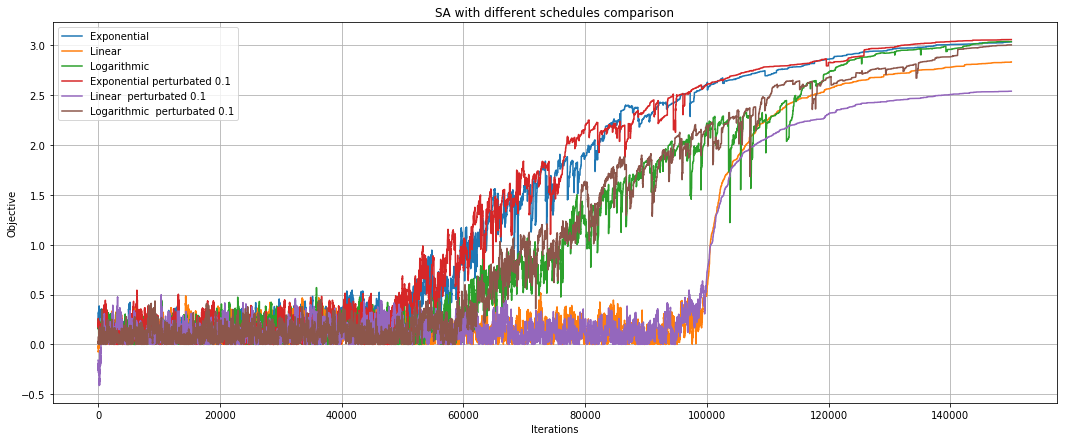

In [17]:
objectives, BestProductPlacement = SimulatedAnnealing(num_steps=150000, t0=30, alpha=0.9999, schedule='exp')
SAobjectives2 = np.array(objectives)
objectives_lin, _ = SimulatedAnnealing(num_steps=150000, t0=30, alpha=0.0003, schedule='lin')
SAobjectives_lin2 = np.array(objectives_lin)
objectives_log, _ = SimulatedAnnealing(num_steps=150000, t0=30, alpha=7e-06, schedule='log')
SAobjectives_log2 = np.array(objectives_log)

plt.figure(figsize=(18, 7))
plt.plot(SAobjectives, label = 'Exponential')
plt.plot(SAobjectives_lin,label = 'Linear')
plt.plot(SAobjectives_log,label = 'Logarithmic')
plt.plot(SAobjectives2, label = 'Exponential perturbated 0.1')
plt.plot(SAobjectives_lin2,label = 'Linear  perturbated 0.1')
plt.plot(SAobjectives_log2,label = 'Logarithmic  perturbated 0.1')
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.title('SA with different schedules comparison')
plt.legend()
plt.grid()
plt.show()

Exponential again performed in the best way. Now let's play with temperature and cooling speed:

In [18]:
objectives1, _ = SimulatedAnnealing(num_steps=150000, t0=1, alpha=0.9999, schedule='exp')
objectives2, _ = SimulatedAnnealing(num_steps=150000, t0=40, alpha=0.9999, schedule='exp')
objectives3, _ = SimulatedAnnealing(num_steps=150000, t0=80, alpha=0.9985, schedule='exp')

/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp


In [19]:
SAobjectives1,SAobjectives2,SAobjectives3 = np.array(objectives1),np.array(objectives2),np.array(objectives3)

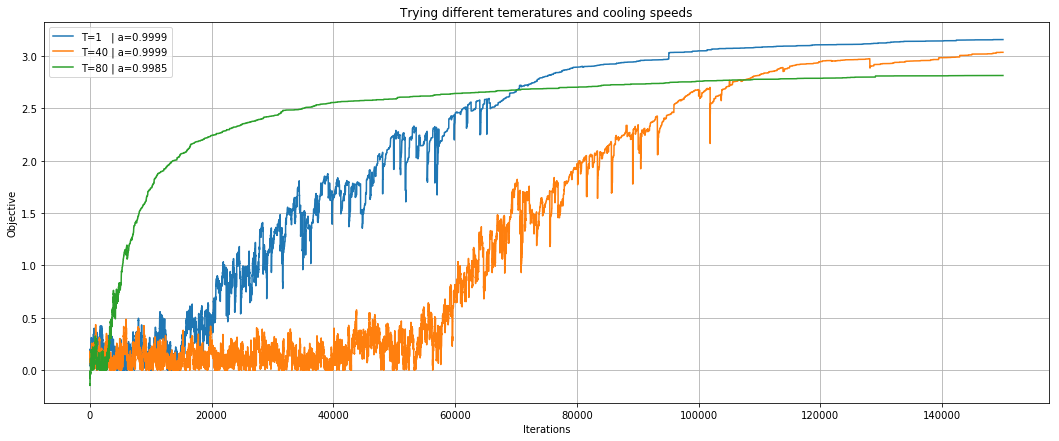

In [20]:
plt.figure(figsize=(18, 7))
plt.plot(SAobjectives1, label = 'T=1   | a=0.9999')
plt.plot(SAobjectives2,label = 'T=40 | a=0.9999')
plt.plot(SAobjectives3,label = 'T=80 | a=0.9985')
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.title('Trying different temeratures and cooling speeds')
plt.legend()
plt.grid()
plt.show()

It's important to see here, that our objective does not rise untill temperature drops significantly. The reason is, in our problem there is no significant difference in objective among neighbors. To actually see some noticable improvement, algorithm needs to make a lot of steps towards better objective. And this is exactly what we see - objective is rising if we are making something like a 100 or 1000 steps towards higher objective to one step towards neigbor with lower objective

In [21]:
print('SA optimized objective:',DeterministicObjective(BestProductPlacement))

SA optimized objective: 3.05365756464


Now lets compare two different initializations:

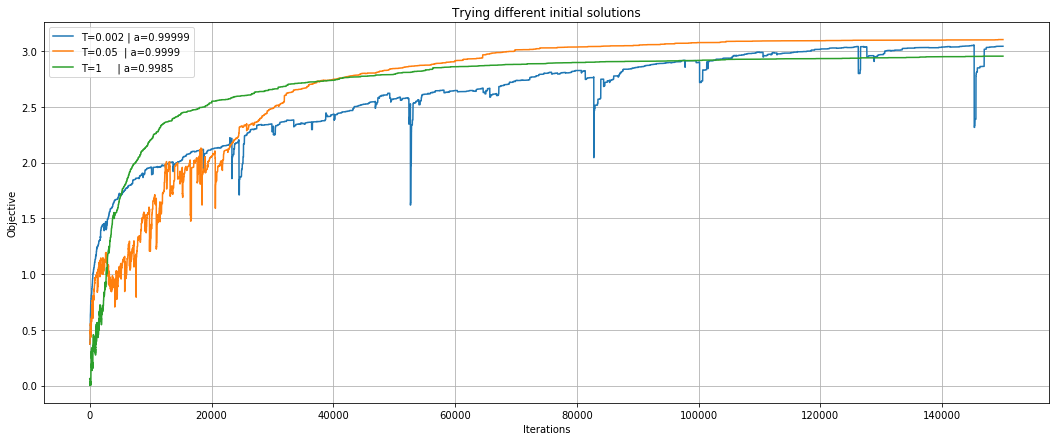

In [22]:
objectives1, _ = SimulatedAnnealing(num_steps=150000, t0=0.002, alpha=0.99999, schedule='exp', init_solution=GenerateCategoricalSolution())
objectives2, _ = SimulatedAnnealing(num_steps=150000, t0=0.05, alpha=0.9999, schedule='exp', init_solution=GenerateCategoricalSolution())
objectives3, _ = SimulatedAnnealing(num_steps=150000, t0=1, alpha=0.9985, schedule='exp')

SAobjectives1,SAobjectives2,SAobjectives3 = np.array(objectives1),np.array(objectives2),np.array(objectives3)

plt.figure(figsize=(18, 7))
plt.plot(SAobjectives1, label = 'T=0.002 | a=0.99999')
plt.plot(SAobjectives2,label =  'T=0.05  | a=0.9999')
plt.plot(SAobjectives3,label =  'T=1     | a=0.9985')
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.title('Trying different initial solutions')
plt.legend()
plt.grid()
plt.show()

It may come out strange that there is a difference in simulated annealing results for different initialization. And although in general this may imply wrong implementation of SA algorithm, we believe this is not the case here. Specificaly, 

Actually, our initial parameters performed pretty well, so let's keep using them. Now let's visualize our initial product placement and product placement after optimization:

###### Visualizing the solution:

In [23]:
cat_color_map1, prob_color_map1, passing_color_map1 = gc.GetGraphColors(ProductPlacement)
cat_color_map2, prob_color_map2, passing_color_map2 = gc.GetGraphColors(BestProductPlacement)

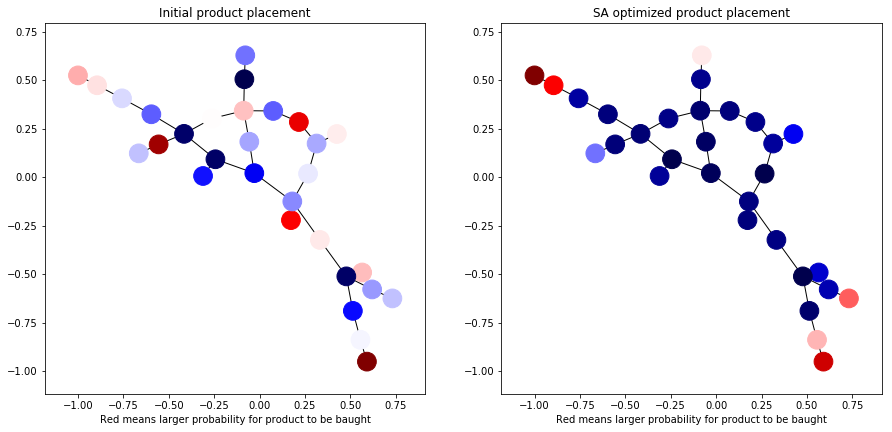

In [24]:
plt.figure(4)
plt.figure(figsize=(15, 15))

plt.subplot(221)
nx.draw_networkx(gc.G, pos=gc.pos,node_color=prob_color_map1,node_size=350, cmap='seismic', with_labels=False)
plt.title('Initial product placement')
plt.xlabel("Red means larger probability for product to be baught")

plt.subplot(222)
nx.draw_networkx(gc.G, pos=gc.pos,node_color=prob_color_map2,node_size=350, cmap='seismic', with_labels=False)
plt.title('SA optimized product placement')
plt.xlabel("Red means larger probability for product to be baught")

plt.show()

We see that our algoritm tends to locate the most popular products in the corners of the shop. Thus, it maximizing the probability that client will get some additional stuff while walking over.

# Genetic algorithm

Parallel with Simulated Annealing we will also try genetics algorithm, which seems attractive, because of no need in whole neighborhood domain observation.<br>

1. In the genetic optimization, we are defining initial set of solutions (population) and sort them according to their objective

2. Randomly choose two solutions among a population (better objective - higher probability to be chosen)

3. Combine these two solutions into a new one (crossover function)

4. On each iteration, there is a probability that some mutation can happen (mutation function)

5. Substitute the solution with the lowest objective in our population with the new one and repeat

In [25]:
def GeneticOptimization(populaton_size=100,num_iter=10000, p_ugly=0.02,p_mutation=0.05, probobalistic=False):
    """Perform a genetic algorithm based optimization.

    Args:
        populaton_size: Number of solutions in the initial set
        num_iter: Number of iterations
        p_ugly: The probability to chose solution with a lower objective as a parent
        p_mutation: The probability of mutation to happen
        probobalistic: if True - calculate probobalistic objective

    Returns:
        Return (Optimized Product Placement - np.ndarray, history - list)
    """

    def crossover(p1, p2):
        child = p1.copy()
        iters = 0
        
        while iters < 50:
            i, j = rint(0, p1.shape[0]), rint(0, p1.shape[1])
            iters += 1
            if p1[i,j] != p2[i,j]:
                break
                
        child[i,j] = p2[i,j].copy()
        if np.sum(child) > n.N:
            bad_row=child[i,:].copy()
            np.put(child[i, :], np.argwhere(bad_row == 1), 0)

        if np.sum(child) < n.N:
            u = j
            while u == j:
                u = rint(0, child.shape[1])
            child[i,u]=1
        return child
    
    def mutation(solution):
        mutated = solution.copy()
        i, j = rint(0, mutated.shape[0]), rint(0, mutated.shape[1])
        exchange_value = mutated[i,j].copy()
        mutated[i,j] = int(not(bool(exchange_value)))
        
        if np.sum(mutated) > n.N:
            bad_row = mutated[i,:].copy()
            np.put(mutated[i, :], np.argwhere(bad_row == 1), 0)
        
        if np.sum(mutated) < n.N:
            u = rint(0, mutated.shape[1])
            while u == j:
                u = rint(0, mutated.shape[1])
            mutated[i, u] = 1
        return mutated
    
    history = []
    population = [GenerateRandomSolution(gc.Shop) for _ in range(populaton_size)]
    
    population_df = pd.DataFrame()
    population_df['Solution'] = population.copy()
    
    if probobalistic:
        population_df['Fitness'] = population_df['Solution'].apply(lambda x: Objective(x)[0]).copy()   
    else:
        population_df['Fitness'] = population_df['Solution'].apply(lambda x: DeterministicObjective(x)).copy()

    population_df = population_df.sort_values('Fitness', ascending=False).reset_index(drop=True)
    history.append(population_df.iat[0,1])
    
    for k in range(num_iter):
        while True:
            p = []
            choice_criterion = np.random.random()
            while len(p) != 2: #the probability that we chose one parent with bad objective
                if choice_criterion < p_ugly:
                    p.append(rint(populaton_size - populaton_size // 10, populaton_size))
                
                #the probability that we chose one parent with medium objective
                elif choice_criterion >= p_ugly and choice_criterion <= 10*p_ugly: 
                    p.append(rint(populaton_size // 10, populaton_size - populaton_size // 10))
                
                else: #the probability that we chose one parent with good objective
                    p.append(rint(0, populaton_size // 10))
            
            if p[0] != p[1]:
                break
                
        f, m = population_df['Solution'][p[0]], population_df['Solution'][p[1]]
        child = crossover(f, m) 
        
        if np.random.random() < p_mutation: # probability that child will mutate
            child = mutation(child)

        population_df.iat[population_df.shape[0] - 1, 0] = child
        if probobalistic:
            population_df.iat[population_df.shape[0] - 1, 1] = Objective(child)[0]
        else:
            population_df.iat[population_df.shape[0] - 1, 1] = DeterministicObjective(child) 
        
        population_df = population_df.sort_values('Fitness', ascending=False).reset_index(drop=True)
        history.append(population_df.iat[0,1])
        
    return population_df.iat[0,0], history

As genetic algorithm is pretty sensetive to initial setting, let's try to tune them.<br>
###### Let's see what happens if we change population size:

In [26]:
_,GeneticObjectives1=GeneticOptimization(populaton_size=200,num_iter=15000, p_ugly=0.02,p_mutation=0.05)
_,GeneticObjectives2=GeneticOptimization(populaton_size=100,num_iter=15000, p_ugly=0.02,p_mutation=0.05)
_,GeneticObjectives3=GeneticOptimization(populaton_size=50,num_iter=15000, p_ugly=0.02,p_mutation=0.05)

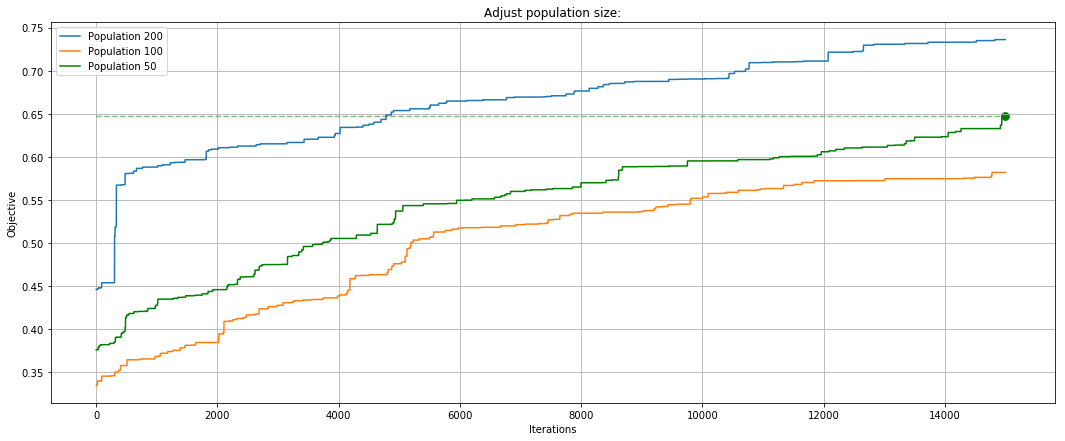

In [27]:
plt.figure(figsize=(18, 7))
plt.title('Adjust population size:')
plt.plot(GeneticObjectives1,label='Population 200')
plt.plot(GeneticObjectives2,label='Population 100')
plt.plot(GeneticObjectives3,label='Population 50', c='g')
plt.plot(np.arange(len(GeneticObjectives3)),[GeneticObjectives3[-1] for _ in range(len(GeneticObjectives3))], c='g',alpha=.5,ls='--')
plt.scatter(len(GeneticObjectives3), GeneticObjectives3[-1],s=60,c='g')
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.grid()
plt.legend()
plt.show()

For our ShopSize=100, the population of 50 seems to be the best choice. We see that increasing the number of solutions above that number does not bring any enhancement (and it's more expensive in terms of calculations).<br>
Decreasing the population size less than 50 may give a short-term improvement, but will result in the lack of diversity later what makes algorithm stuck in local minima<br>
###### Let's next play with a probability to select a solution with a lower objective as a one of the parent:

In [28]:
_,GeneticObjectives1=GeneticOptimization(populaton_size=50,num_iter=15000, p_ugly=0.02,p_mutation=0.05)
_,GeneticObjectives2=GeneticOptimization(populaton_size=50,num_iter=15000, p_ugly=0.07,p_mutation=0.05)
_,GeneticObjectives3=GeneticOptimization(populaton_size=50,num_iter=15000, p_ugly=0.1,p_mutation=0.05)
_,GeneticObjectives4=GeneticOptimization(populaton_size=50,num_iter=15000, p_ugly=0.0002,p_mutation=0.05)

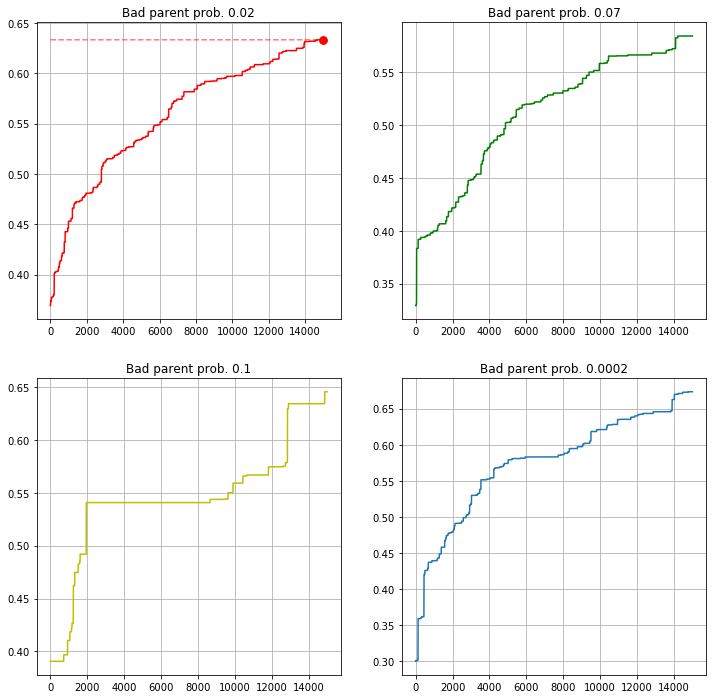

In [29]:
plt.figure(1)
plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.plot(GeneticObjectives1,c='r')
plt.plot(np.arange(len(GeneticObjectives1)), [GeneticObjectives1[-1] for _ in range(len(GeneticObjectives1))],c='r', alpha=0.5,ls='--')
#plt.plot(x=[len(GeneticObjectives1) for _ in range(len(GeneticObjectives1))],y=np.arange(GeneticObjectives1[-1]),c='r', alpha=0.5)
plt.scatter(len(GeneticObjectives1), GeneticObjectives1[-1],s=60,c='r')
plt.title('Bad parent prob. 0.02')
plt.grid()
# log
plt.subplot(222)
plt.plot(GeneticObjectives2,c='g')
plt.title('Bad parent prob. 0.07')
plt.grid()
# symmetric log
plt.subplot(223)
plt.plot(GeneticObjectives3,c='y')
plt.title('Bad parent prob. 0.1')
plt.grid()
# logit
plt.subplot(224)
plt.plot(GeneticObjectives4)
plt.title('Bad parent prob. 0.0002')
plt.grid()

plt.show()

We see that the best results is gained with low probability (not too low) what seems natural.<br>

###### The last thing we need to adjust is the probability of mutations:

In [30]:
_,GeneticObjectives1=GeneticOptimization(populaton_size=50,num_iter=15000, p_ugly=0.0002,p_mutation=0.00002)
_,GeneticObjectives2=GeneticOptimization(populaton_size=50,num_iter=15000, p_ugly=0.0002,p_mutation=0.1)
_,GeneticObjectives3=GeneticOptimization(populaton_size=50,num_iter=15000, p_ugly=0.0002,p_mutation=0.4)
_,GeneticObjectives4=GeneticOptimization(populaton_size=50,num_iter=15000, p_ugly=0.0002,p_mutation=0.6)
_,GeneticObjectives5=GeneticOptimization(populaton_size=50,num_iter=15000, p_ugly=0.0002,p_mutation=0.9)

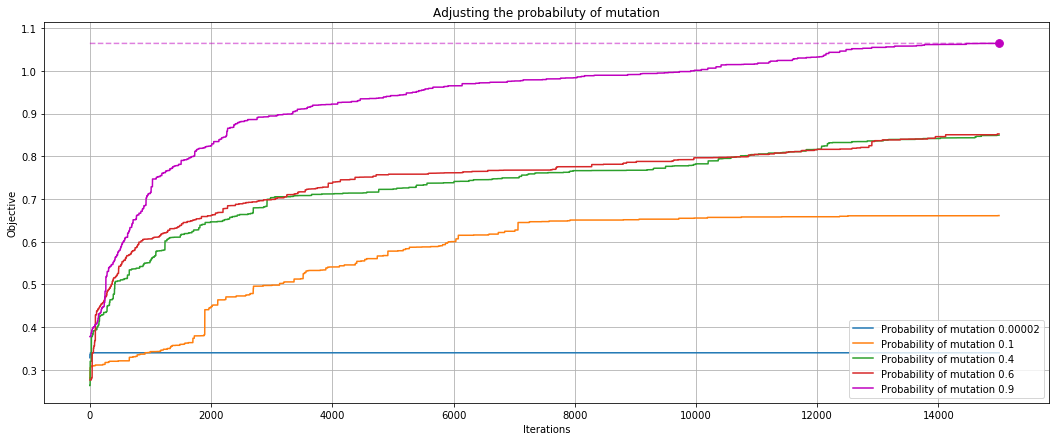

In [31]:
plt.figure(figsize=(18, 7))
plt.title('Adjusting the probabiluty of mutation')
plt.plot(GeneticObjectives1,label='Probability of mutation 0.00002')
plt.plot(GeneticObjectives2,label='Probability of mutation 0.1')
plt.plot(GeneticObjectives3,label='Probability of mutation 0.4')
plt.plot(GeneticObjectives4,label='Probability of mutation 0.6')
plt.plot(GeneticObjectives5,label='Probability of mutation 0.9',c='m')
plt.scatter(len(GeneticObjectives5),GeneticObjectives5[-1], s=60,c='m')
plt.plot(np.arange(len(GeneticObjectives5)),[GeneticObjectives5[-1] for _ in range(len(GeneticObjectives5))], c='m',alpha=.5,ls='--')
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.grid()
plt.legend()
plt.show()

We see that our algorithm loves mutations. They bring some randomness and support a required diversity to prevent genetic algorithm from falling into local minima. So, let's try an optimal set of parameters on our optimization problem

##### Optimal solution visualization:

In [32]:
GBestProducPlacement,GeneticObjectives1 = GeneticOptimization(populaton_size=50,num_iter=150000,p_ugly=0.002,p_mutation=0.9)

In [33]:
cat_color_map3, prob_color_map3, passing_color_map3 = gc.GetGraphColors(GBestProducPlacement)
print('Genetic optimized objective:',DeterministicObjective(GBestProducPlacement))

Genetic optimized objective: 1.31933940869


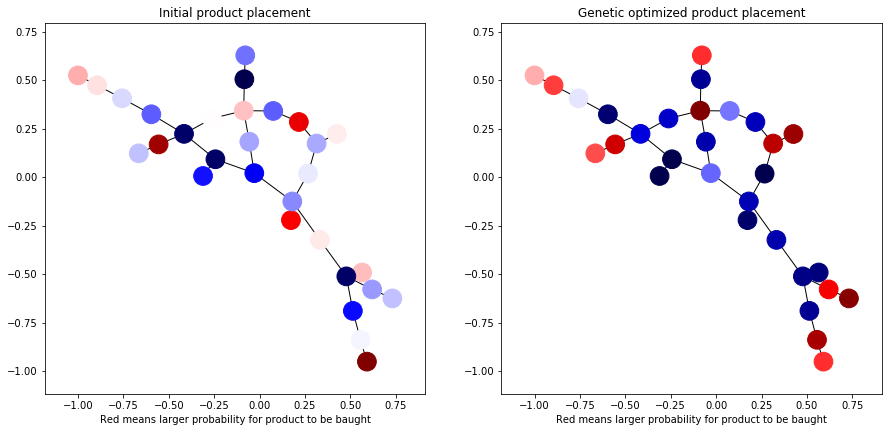

In [34]:
plt.figure(2)
plt.figure(figsize=(15, 15))

plt.subplot(221)
nx.draw_networkx(gc.G, pos=gc.pos,node_color=prob_color_map1,node_size=350, cmap='seismic', with_labels=False)
plt.title('Initial product placement')
plt.xlabel("Red means larger probability for product to be baught")
# log
plt.subplot(222)
nx.draw_networkx(gc.G, pos=gc.pos,node_color=prob_color_map3,node_size=350, cmap='seismic', with_labels=False)
plt.title('Genetic optimized product placement')
plt.xlabel("Red means larger probability for product to be baught")

plt.show()

Let's now compare Simulated Annealing and Genetic Algorithm. What algorithm works faster, how do they converge, what objective is higher and so on.

### Simulated Annealing vs Genetic Algorithm

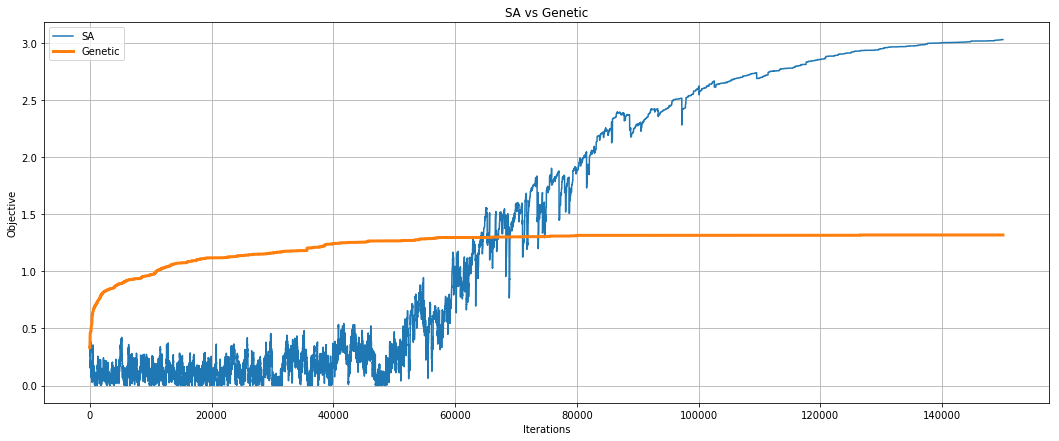

In [35]:
plt.figure(figsize=(18, 7))
plt.grid()
plt.title('SA vs Genetic')
plt.plot(SAobjectives, label='SA')
plt.plot(GeneticObjectives1,label='Genetic',lw=3)
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.legend()
plt.show()

In [36]:
print('SA optimized objective:',DeterministicObjective(BestProductPlacement))
print('Genetic optimized objective:',DeterministicObjective(GBestProducPlacement))

SA optimized objective: 3.05365756464
Genetic optimized objective: 1.31933940869


 - Genetic Algorithm converges to the local optima faster, but its iterations are 4.5 times more expencive :(

In [37]:
%time _,_= GeneticOptimization(populaton_size=50,num_iter=100,p_ugly=0.002,p_mutation=0.9)
print()
%time _,_= SimulatedAnnealing(num_steps=100, t0=30, alpha=0.9999, schedule='exp')

CPU times: user 480 ms, sys: 20 ms, total: 500 ms
Wall time: 256 ms

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 81.7 ms


And here are solutions that they produce:

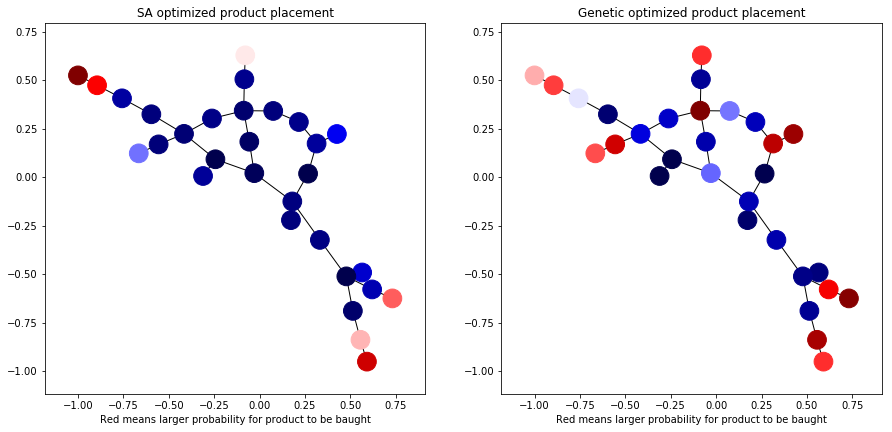

In [39]:
plt.figure(3)
plt.figure(figsize=(15, 15))

plt.subplot(221)
nx.draw_networkx(gc.G, pos=gc.pos,node_color=prob_color_map2,node_size=350, cmap='seismic', with_labels=False)
plt.title('SA optimized product placement')
plt.xlabel("Red means larger probability for product to be baught")
# log
plt.subplot(222)
nx.draw_networkx(gc.G, pos=gc.pos,node_color=prob_color_map3,node_size=350, cmap='seismic', with_labels=False)
plt.title('Genetic optimized product placement')
plt.xlabel("Red means larger probability for product to be baught")

plt.show()